# HmbFR

In [ ]:
import pathlib
import sys
from pathlib import Path

project_root = Path.cwd()
if (project_root / "predicting-cyclodextrin-bioavailability").is_dir():
    project_root = project_root / "predicting-cyclodextrin-bioavailability"

sys.path.append(str(project_root))

from scripts.utils import env_variables as env

DATASETS = [
    {"name": "with_vecs_new",    "path": pathlib.Path(env.CLEAN_DATA_DIR) / "dataset_with_vec_expanded_scaled.parquet"},
    {"name": "without_vecs_new", "path": pathlib.Path(env.CLEAN_DATA_DIR) / "dataset_without_vec_expanded_scaled.parquet"},
    # np. {"name": "another", "path": "data/new/another.csv"},
]

TARGET_COL = "DeltaG"      
PROBLEM    = "auto"        
N_BINS     = 3             

PALETTE_KIND = "32"        # '16' or '32'
USE_BACKWARD = True        # forward + backward
AGG_FEATURES = "max"      
GROUP_SIZE   = 3           # RGB like

TOPK_LIST = [32, 64, 128]


OUT_DIR = pathlib.Path(env.OUTPUT_HMBFR_DIR)
OUT_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42


# Importy i weryfikacja środowiska
- Upewniamy się, że `hmbfr` jest importowalny z aktualnego kernela (Poetry venv),
- Przygotowujemy podstawowe biblioteki.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hmbfr import HmbFR, HmbFRSelector, html16_palette, html32_palette

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# Functions

In [ ]:
from typing import Dict, Tuple, List, Optional

def load_dataframe(path: str | pathlib.Path) -> pd.DataFrame:
    """Load DataFrame from CSV or Parquet."""
    path = pathlib.Path(path)
    if not path.exists():
        raise FileNotFoundError(f"Dataset not found: {path}")
    if path.suffix.lower() in [".parquet", ".pq"]:
        return pd.read_parquet(path)
    # domyślnie CSV (spróbuj inteligentnie)
    try:
        return pd.read_csv(path)
    except Exception:
        # fallback: europejski separator
        return pd.read_csv(path, sep=";", decimal=",", on_bad_lines="skip")


def drop_constant_columns(df: pd.DataFrame,
                          keep: Optional[List[str]] = None,
                          dropna: bool = False) -> Tuple[pd.DataFrame, List[str]]:
    """Drop columns that have <= 1 unique value."""
    keep = set(keep or [])
    const = [c for c in df.columns if c not in keep and df[c].nunique(dropna=dropna) <= 1]
    return df.drop(columns=const, errors="ignore").copy(), const


def handle_missing(df: pd.DataFrame,
                   target: Optional[str] = None,
                   col_thresh: float | None = 0.98,
                   row_thresh: float | None = None,
                   impute_num: str = "median",
                   impute_cat: str = "mode") -> Tuple[pd.DataFrame, Dict]:
    """
    Imputation and optional columns and rows dropping
    """
    meta = {}
    dfc = df.copy()

    if col_thresh is not None:
        na_frac = dfc.isna().mean()
        drop_cols = list(na_frac[na_frac >= col_thresh].index)
        dfc = dfc.drop(columns=drop_cols)
        meta["dropped_cols_missing"] = drop_cols

    if row_thresh is not None:
        row_na = dfc.isna().mean(axis=1)
        drop_rows = list(row_na[row_na >= row_thresh].index)
        dfc = dfc.drop(index=drop_rows)
        meta["dropped_rows_missing"] = len(drop_rows)

    num_cols = dfc.select_dtypes(include="number").columns.tolist()
    if target and target in num_cols:
        # nie imputuj celu „na siłę”
        num_cols = [c for c in num_cols if c != target]

    if num_cols:
        fill = (dfc[num_cols].median() if impute_num == "median" else dfc[num_cols].mean())
        dfc[num_cols] = dfc[num_cols].fillna(fill)

    cat_cols = [c for c in dfc.columns if c not in num_cols]
    if target and target in cat_cols:
        cat_cols = [c for c in cat_cols if c != target]

    if cat_cols:
        modes = {c: (dfc[c].mode(dropna=True).iloc[0] if not dfc[c].mode(dropna=True).empty else "") 
                 for c in cat_cols}
        dfc[cat_cols] = dfc[cat_cols].fillna(pd.Series(modes))

    meta["remaining_nan"] = int(dfc.isna().sum().sum())
    return dfc, meta


def make_overview(df: pd.DataFrame) -> pd.DataFrame:
    """Returns overview table."""
    return (
        pd.DataFrame({
            "dtype": df.dtypes,
            "non_null": df.count(),
            "nulls": df.isna().sum(),
            "null_%": df.isna().mean() * 100,
            "unique_cnt": df.nunique(dropna=True),
        })
        .sort_values("null_%", ascending=False)
    )


def plot_scores(scores: pd.Series, title: str, top: int = 40, out_path: Optional[pathlib.Path] = None):
    """Shows bar chart for TOP-N results HmbFR."""
    topn = scores.head(top)[::-1]  # odwróć, by najwyższe były na górze
    plt.figure(figsize=(8, max(4, 0.25 * len(topn))))
    plt.barh(range(len(topn)), topn.values)
    plt.yticks(range(len(topn)), topn.index, fontsize=8)
    plt.title(title)
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()


def report_top_correlations(df: pd.DataFrame, view_name: str, out_dir: pathlib.Path,
                            topk: int = 50, min_abs: float = 0.7) -> pd.DataFrame:
    """Saves and returns top-k pairs."""
    num = df.select_dtypes(include="number")
    if num.shape[1] < 2:
        return pd.DataFrame()
    corr = num.corr().abs()
    pairs = []
    cols = corr.columns
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            r = corr.iloc[i, j]
            if np.isnan(r): 
                continue
            if r >= min_abs:
                pairs.append((cols[i], cols[j], float(r)))
    pairs.sort(key=lambda x: x[2], reverse=True)
    df_pairs = pd.DataFrame(pairs[:topk], columns=["feature_1","feature_2","abs_r"])
    if not df_pairs.empty:
        out_dir.mkdir(parents=True, exist_ok=True)
        md_path = out_dir / f"{view_name}_top_correlations.md"
        df_pairs.to_markdown(md_path, index=False)
        print(f"[{view_name}] zapisano: {md_path}")
    return df_pairs


def plot_color_histograms_for_top_groups(ranker: HmbFR,
                                         X_df: pd.DataFrame,
                                         y_labels: np.ndarray,
                                         top_groups: int = 5,
                                         title_prefix: str = "",
                                         out_dir: Optional[pathlib.Path] = None):
    """
    Saves bar charts for p(color|class).
    """
    pal = ranker.palette if ranker.palette is not None else (html32_palette() if PALETTE_KIND=="32" else html16_palette())
    K = pal.shape[0]
    classes = np.unique(y_labels)

    # policz grupy i ich score (forward)
    groups = ranker.groups_fwd_
    scores = ranker.group_scores_fwd_
    if groups is None or scores is None or len(scores) == 0:
        print("[plot_color_histograms_for_top_groups] Brak grup forward.")
        return

    top_idx = np.argsort(-scores)[:min(top_groups, len(scores))]
    # skompresuj trybem 'compress' i wybierz tylko forward część
    Q_all = ranker.transform(X_df, mode="compress")
    # jeśli był backward, Q_all zawiera [Gf | Gb] – obetnij do Gf
    Gf = groups.shape[0]
    Qf = Q_all[:, :Gf]

    for rank_pos, j in enumerate(top_idx, start=1):
        col = Qf[:, j]
        # macierz P(color|class)
        P = np.zeros((len(classes), K), dtype=float)
        for ci, c in enumerate(classes):
            vals = col[y_labels == c]
            if vals.size:
                P[ci] = np.bincount(vals, minlength=K)
        P = (P + ranker.smoothing) / (P.sum(axis=1, keepdims=True) + ranker.smoothing * K)

        plt.figure(figsize=(10, 3 + 0.3*len(classes)))
        for ci, c in enumerate(classes):
            ax = plt.subplot(len(classes), 1, ci+1)
            ax.bar(range(K), P[ci], width=0.8)
            ax.set_ylim(0, P.max()*1.05)
            ax.set_xticks(range(K))
            ax.set_xticklabels([str(i) for i in range(K)], fontsize=7)
            ax.set_ylabel(f"class={c}", rotation=0, labelpad=30, ha="right", va="center")
            if ci == 0:
                ax.set_title(f"{title_prefix} Top group #{rank_pos} (idx={j}) – color distributions")
        plt.tight_layout()
        if out_dir:
            out_dir.mkdir(parents=True, exist_ok=True)
            plt.savefig(out_dir / f"{title_prefix.strip().replace(' ','_')}_group{rank_pos}_colors.png",
                        dpi=200, bbox_inches="tight")
        plt.show()


# Loading new datasets


In [13]:
loaded: Dict[str, pd.DataFrame] = {}
cleaned: Dict[str, pd.DataFrame] = {}
meta_info: Dict[str, Dict] = {}

for spec in DATASETS:
    name = spec["name"]
    path = spec["path"]
    print(f"\n=== Loading: {name} from {path} ===")
    df = load_dataframe(path)

    # Overview
    ov = make_overview(df)
    try:
        display(ov.head(20))
    except Exception:
        print(ov.head(20))

    # Missing & constants
    dfc, meta = handle_missing(df, target=TARGET_COL, col_thresh=0.98, row_thresh=None)
    dfc, const = drop_constant_columns(dfc, keep=[TARGET_COL] if TARGET_COL else [], dropna=False)
    meta["const_dropped"] = const

    print(f"[{name}] remaining_nan={meta.get('remaining_nan')} | dropped_const={len(const)}")
    loaded[name]  = df
    cleaned[name] = dfc
    meta_info[name] = meta



=== Loading: with_vecs_new from data/clean/dataset_with_vec_expanded_scaled.parquet ===


,dtype,non_null,nulls,null_%,unique_cnt
DeltaG,float64,980,0,0.0,648
TPSA,float64,980,0,0.0,281
MolecularWeight,float64,980,0,0.0,690
Complexity,float64,980,0,0.0,729
Charge,float64,980,0,0.0,6
HBondDonorCount,float64,980,0,0.0,8
HBondAcceptorCount,float64,980,0,0.0,12
HeavyAtomCount,float64,980,0,0.0,36
MolLogP,float64,980,0,0.0,770
iso2vec-0,float64,980,0,0.0,953


[with_vecs_new] remaining_nan=0 | dropped_const=0

=== Loading: without_vecs_new from data/clean/dataset_without_vec_expanded_scaled.parquet ===


,dtype,non_null,nulls,null_%,unique_cnt
DeltaG,float64,980,0,0.0,648
TPSA,float64,980,0,0.0,281
MolecularWeight,float64,980,0,0.0,690
Complexity,float64,980,0,0.0,729
Charge,float64,980,0,0.0,6
HBondDonorCount,float64,980,0,0.0,8
HBondAcceptorCount,float64,980,0,0.0,12
HeavyAtomCount,float64,980,0,0.0,36
MolLogP,float64,980,0,0.0,770
Amide (Fragment Counts),float64,980,0,0.0,2


[without_vecs_new] remaining_nan=0 | dropped_const=0


# Run HmbFR



=== HmbFR on: with_vecs_new ===


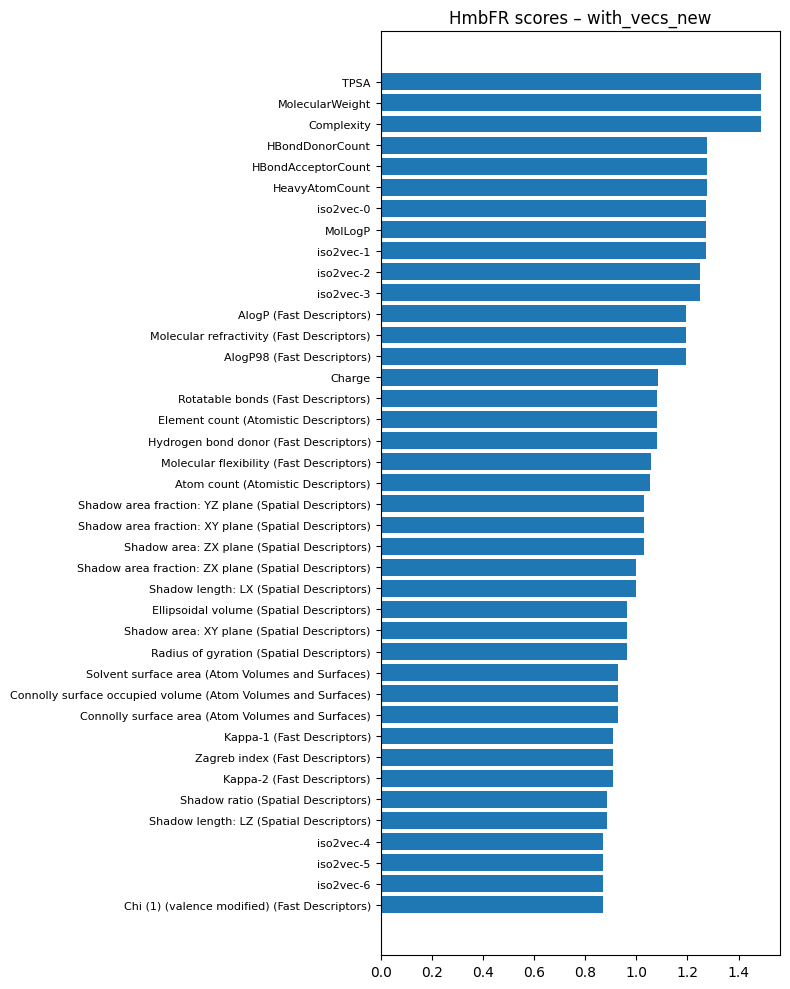

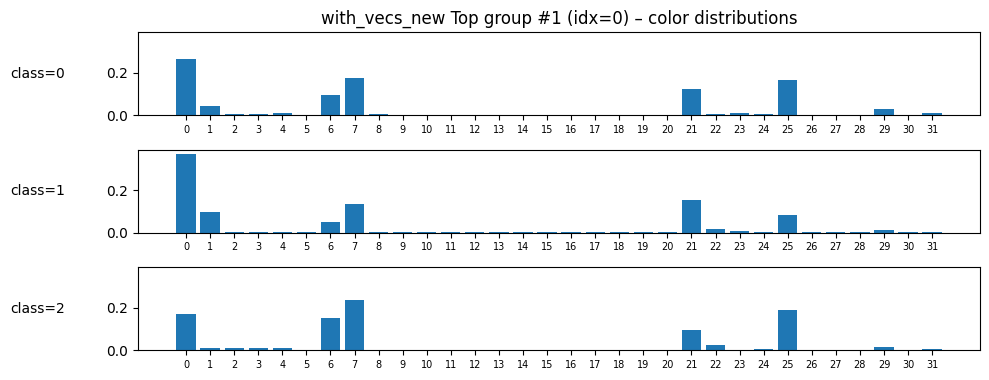

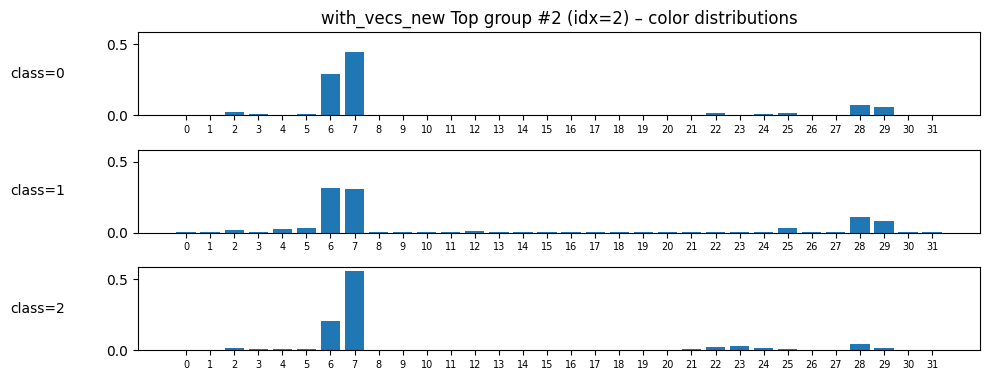

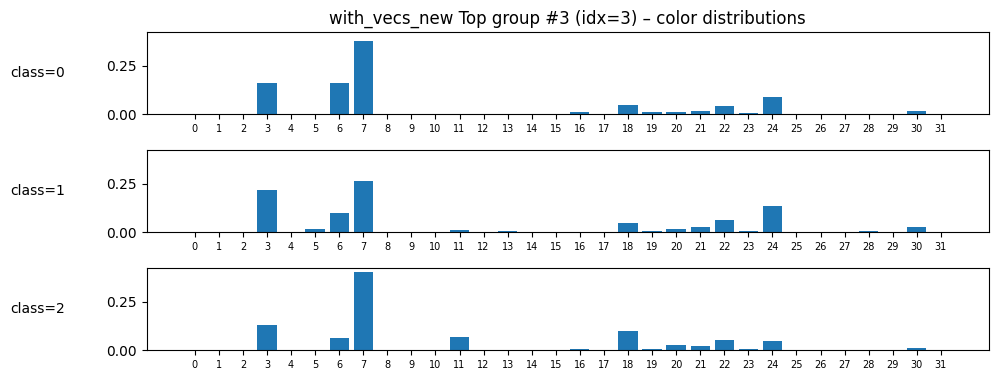

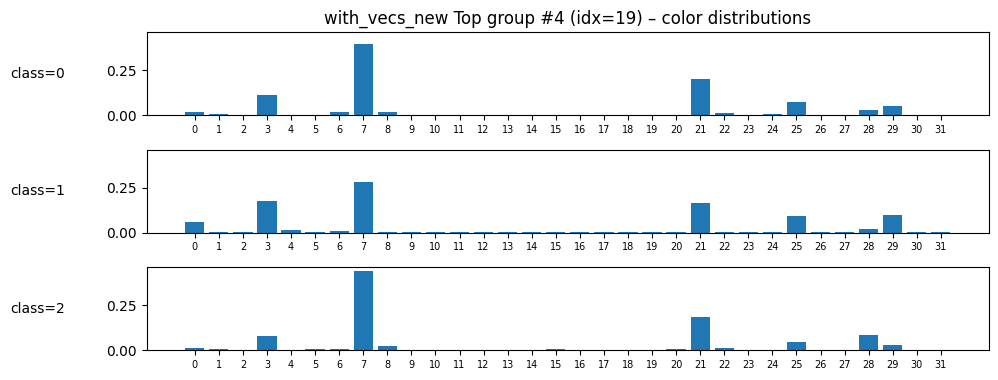

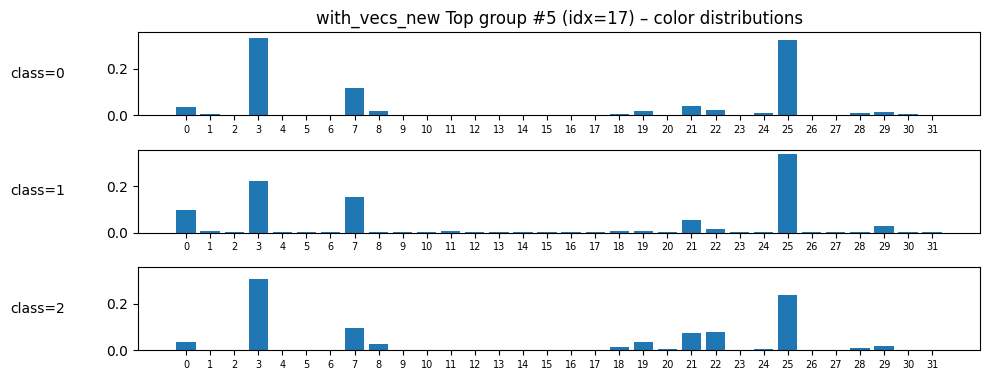


=== HmbFR on: without_vecs_new ===


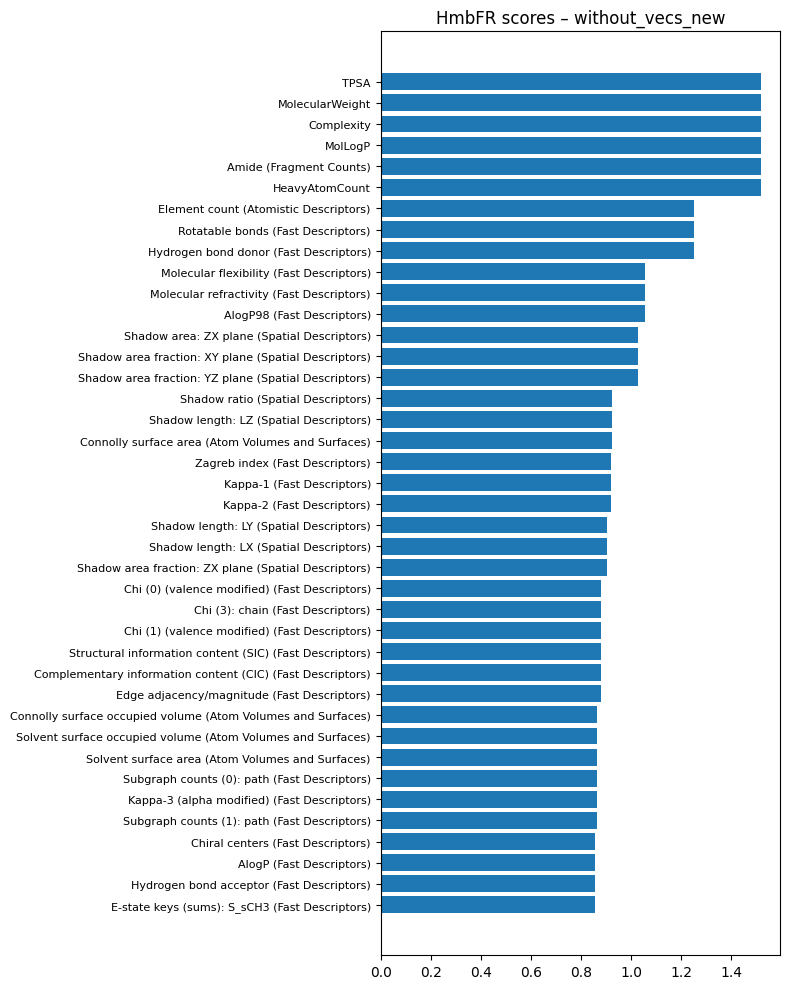

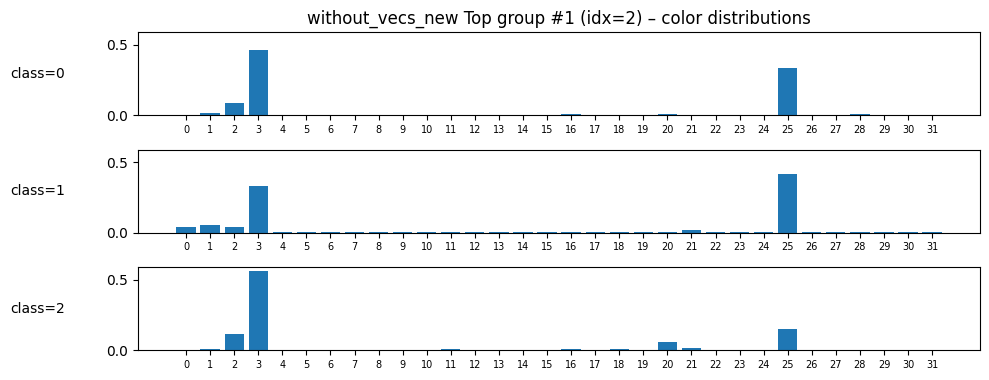

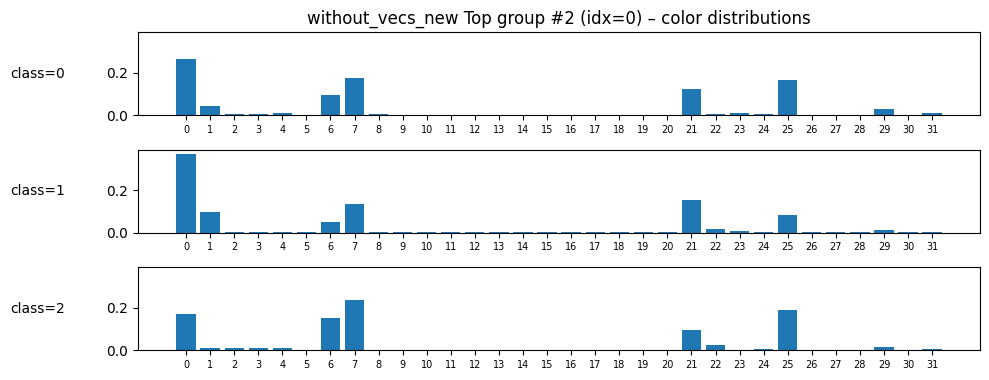

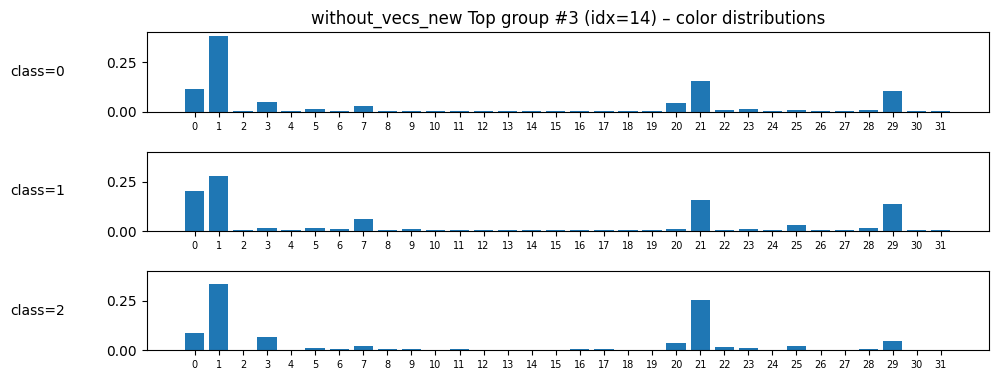

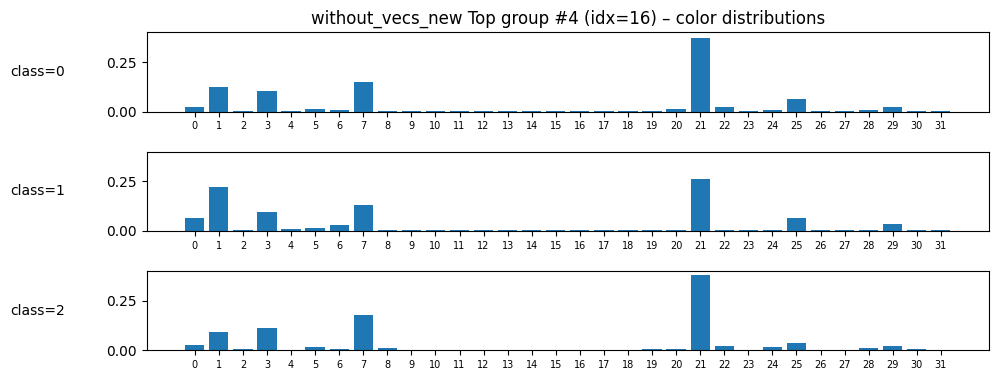

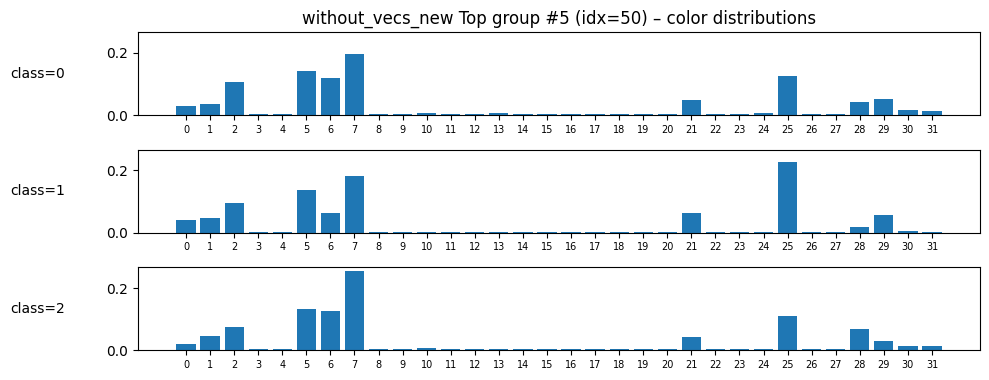

In [ ]:
def detect_problem(y: pd.Series, mode: str = "auto") -> str:
    if mode in ("regression", "classification"):
        return mode
    if pd.api.types.is_numeric_dtype(y):
        return "regression" if y.nunique() > 10 else "classification"
    return "classification"

reports: Dict[str, Dict] = {}

for name, dfc in cleaned.items():
    print(f"\n=== HmbFR on: {name} ===")
    if TARGET_COL and TARGET_COL in dfc.columns:
        y = dfc[TARGET_COL]
        X = dfc.drop(columns=[TARGET_COL])
    else:
        y = pd.Series(np.zeros(len(dfc), dtype=int), index=dfc.index)  
        X = dfc

    Xn = X.select_dtypes(include="number").copy()
    problem = detect_problem(y, PROBLEM)

    palette = html32_palette() if PALETTE_KIND == "32" else html16_palette()

    cls_strategy = "quantile" if problem == "regression" else "given"

    ranker = HmbFR(
        class_strategy=cls_strategy,
        n_bins=N_BINS,
        palette=palette,
        use_backward=USE_BACKWARD,
        agg_features=AGG_FEATURES,
        group_size=GROUP_SIZE,
    )

    ranker.fit(Xn, y)
    scores = pd.Series(ranker.feature_importances_, index=Xn.columns).sort_values(ascending=False)

    out_dir = OUT_DIR / name
    out_dir.mkdir(parents=True, exist_ok=True)
    scores.to_csv(out_dir / "hmbfr_feature_scores.csv", header=["score"])
    scores.head(100).to_markdown(out_dir / "hmbfr_top100.md")

    
    plot_scores(scores, title=f"HmbFR scores – {name}", top=40, out_path=out_dir / "hmbfr_top40.png")

    
    if problem == "regression":
        q = pd.qcut(y, q=N_BINS, duplicates="drop")
        y_labels = pd.factorize(q)[0]
    else:
        y_labels = pd.factorize(y)[0]

    plot_color_histograms_for_top_groups(ranker, Xn, y_labels,
                                         top_groups=5,
                                         title_prefix=name,
                                         out_dir=out_dir)

    # metryki sanity (np. udział sumy top-k)
    cum = scores.cumsum() / scores.sum()
    cum.head(50).to_csv(out_dir / "cumulative_share_first50.csv")
    reports[name] = {
        "problem": problem,
        "scores": scores,
        "cum_share": cum,
        "ranker": ranker,
        "X": Xn,
        "y": y,
    }


# Model comparison: baseline vs HmbFR TOP-K

In [ ]:
from collections import defaultdict

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
results = defaultdict(list)

for name, pack in reports.items():
    X = pack["X"]; y = pack["y"]; problem = pack["problem"]
    scores = pack["scores"]; ranker = pack["ranker"]

    # baseline 
    if problem == "regression":
        base = Pipeline([("sc", StandardScaler(with_mean=True, with_std=True)),
                         ("m", Ridge(alpha=1.0, random_state=RANDOM_STATE))])
        metric = "neg_mean_squared_error"
        base_cv = -cross_val_score(base, X, y, cv=cv, scoring=metric)
        results[name].append(("baseline_all", "MSE", base_cv.mean(), base_cv.std()))
    else:
        base = Pipeline([("sc", StandardScaler(with_mean=True, with_std=True)),
                         ("m", LogisticRegression(max_iter=200, random_state=RANDOM_STATE))])
        metric = "accuracy"
        base_cv = cross_val_score(base, X, y, cv=cv, scoring=metric)
        results[name].append(("baseline_all", "ACC", base_cv.mean(), base_cv.std()))

    # HmbFR TOP-K
    for k in TOPK_LIST:
        sel = HmbFRSelector(top_k=k,
                            class_strategy=("quantile" if problem=="regression" else "given"),
                            n_bins=N_BINS,
                            palette=(html32_palette() if PALETTE_KIND=="32" else html16_palette()),
                            use_backward=USE_BACKWARD,
                            agg_features=AGG_FEATURES)

        if problem == "regression":
            pipe = Pipeline([("sel", sel),
                             ("sc", StandardScaler(with_mean=True, with_std=True)),
                             ("m", Ridge(alpha=1.0, random_state=RANDOM_STATE))])
            cv_scores = -cross_val_score(pipe, X, y, cv=cv, scoring="neg_mean_squared_error")
            results[name].append((f"hmbfr_top{k}", "MSE", cv_scores.mean(), cv_scores.std()))
        else:
            pipe = Pipeline([("sel", sel),
                             ("sc", StandardScaler(with_mean=True, with_std=True)),
                             ("m", LogisticRegression(max_iter=200, random_state=RANDOM_STATE))])
            cv_scores = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy")
            results[name].append((f"hmbfr_top{k}", "ACC", cv_scores.mean(), cv_scores.std()))

for name, rows in results.items():
    dfres = pd.DataFrame(rows, columns=["variant", "metric", "mean", "std"])
    display(dfres)
    dfres.to_markdown(OUT_DIR / name / "model_comparison.md", index=False)
    dfres.to_csv(OUT_DIR / name / "model_comparison.csv", index=False)


,variant,metric,mean,std
0,baseline_all,MSE,14.119853,1.702070
1,hmbfr_top32,MSE,14.723506,1.454147
2,hmbfr_top64,MSE,14.558310,1.713250
3,hmbfr_top128,MSE,15.756762,5.116087


,variant,metric,mean,std
0,baseline_all,MSE,14.198253,1.601633
1,hmbfr_top32,MSE,14.901891,1.492594
2,hmbfr_top64,MSE,14.301443,1.056319
3,hmbfr_top128,MSE,14.423674,2.479107
